# Worksheet 2: Using the Python Iris library for analysis and visualisation

In this worksheet, sample PRECIS output over Southeast Asia is compared with observations for validation purposes. Validating model results by comparing with observed data is an essential step - this is the measure by which we can assess the quality of the model and it informs appropriate uses of the data.


Here, we validate PRECIS output driven by two different GCMs (HadCM3Q0 and ECHAM5). Using data from both experiments will give us two representations of present day climate and two possible climate scenarios. For more details on multimodel approaches, refer to the PRECIS workshop lecture on climate model ensembles.

The following exercises provide examples of how analysis can be undertaken as part of a model validation. The methods shown are not necessarily the only way to proceed and are intended to demonstrate the use of Iris in model validation, and provide a starting point for your own analyses. For further help on validating your PRECIS simulations, refer to the PRECIS workshop lecture on model evaluation.

<div class="alert alert-block alert-warning">
<b>By the end of this worksheet you should be able to:</b><br> 
- Apply basic statistical operations to Iris cubes. <br>
- Plot information from Iris cubes.<br>
- Code a basic python workflow for undertaking basic temperature and rainfall analysis
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> The data used here has been processed in the same way as Worksheet 1. The 8 point-rim has been removed and it has been converted from PP to NetCDF format.
</div>

## Contents
### [2.1: Inspecting the data](#2.1) 
### [2.2: Converting units](#2.2)
### [2.3: Climatological mean calculation](#2.3)
### [2.4: IRIS quick plotting and visualising data](#2.4)
### [2.5: Mean annual cycle calculation](#2.5)
### [2.6: Comparing models and observations](#2.6)
### [2.7: Climatological mean and annual cycle for an ensemble](#2.7)

## Preamble

**a)** Run the code preamble below to import the necessary libraries for this worksheet.

To run the code, click in the box below and press <kbd>Ctrl</kbd> + <kbd>Enter</kbd>.

In [1]:
# Code preamble - these libraries will be used in this worksheet.
# This code block needs to be re-run every time you restart this worksheet!
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import calendar
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes

<a id='2.1'></a>
# 2.1 Inspecting the data

The datasets used here contain daily and monthly data from two PRECIS runs carried out over Southeast Asia, one driven by HadCM3Q0 and the other driven by ECHAM5. The observations used for comparison are from the APHRODITE gridded observational data set (http://www.chikyu.ac.jp/precip/english/index.html).
<p><img src="img/two_runids.jpg" alt="PRECIS runid flow" style="float: center; height: 200px;"/></p>

In Iris, data are read into an object called a **cube**. A cube contains the data of interest (e.g., temperature, rainfall, wind speeds) and metadata about that variable. A single cube describes only one variable; it is not possible for a cube to contain both temperature and rainfall, for example. A cube always has a name, a unit and an n-dimensional data array to represents the cube’s data. Additionally, the cube contains collections of coordinates.  Coordinate types can include spatial information (latitude, longitude, altitude), a time dimension, or other information, e.g., an ensemble number.

<p><img src="img/multi_array_to_cube.png" alt="Example Iris cube" style="float: center; height: 300px;"/></p>


__b) Load the NetCDF file for the HadCM3Q0 and ECHAM5 model data and the APHRODITE rainfall observation data and print the cube output__

A cube has coordinates (e.g. time, longitude, latitude, model levels) which can be accessed with Python commands. In the following exercise we find the latitude and longitude covered by the APHRODITE data. This can be done by printing the latitude and longitude coordinates (`.points`), noting the first and last values in the array. A similar example can be found in the [Iris documentation](http://scitools.org.uk/iris/docs/latest/userguide/navigating_a_cube.html#accessing-coordinates-on-the-cube) and 

Before running the code, take a look at it line by line to understand what steps are being taken. Then click in the box and press <kbd>ctrl</kbd> + <kbd>enter</kbd> to run the code.

In [3]:
# Provide the names of the directories where the netCDF model files are stored
DATADIR = '/project/precis/worksheets/data/'
path_in_cahpa   = os.path.join(DATADIR, 'netcdf/cahpa/')
path_in_cahpb   = os.path.join(DATADIR, 'netcdf/cahpb/')
path_in_APHRODITE   = os.path.join(DATADIR, 'APHRODITE/')

# Load and print the HadCM3Q0 (cahpa) model cube data
cahpaData = iris.load_cube(path_in_cahpa + 'cahpa.pm.1981_1983.pr.norim.nc')

# Load and print the ECHAM5 (cahpb) model cube data
cahpbData = iris.load_cube(path_in_cahpb + 'cahpb.pm.1981_1983.pr.norim.nc')

# Load and print the APHRODITE observation cube data
aphroData = iris.load_cube(path_in_APHRODITE + 'aphro.mon.6190.nc')

<div class="alert alert-block alert-success">
<b>Question:</b> Given the name of the APHRODITE file, which years of data do you expect should be contained in the file?<br>
You can check your answer by adapting the code that follows. 
</div>

__c) Extract a subset of the data within a cube__

Data extraction is an important function in Iris. The extraction of a subset of data is called **slicing**.  For example, it could be necessary to extract data over all latitude and longitude grid points on the first time step. For more information around subsetting cubes please read the [Iris documentation on slicing](http://scitools.org.uk/iris/docs/latest/userguide/subsetting_a_cube.html#cube-indexing).

__Using the HadCM3Q0 data, the example below shows how to subset a cube for the first and last timesteps. This method will be used later for plotting data from a cube.__ 

Work through the example below line by line then click in the box and press <kbd>Ctrl</kbd> + <kbd>Enter</kbd> to run the code.

First, print the HadCM3QO (cahpa) cube, containing all the time steps:

In [4]:
cahpaData

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 36; grid_latitude: 192; grid_longitude: 192)>

<div class="alert alert-block alert-success">
<b>Question:</b> What dimensions does this cube have? <br>
    x = number of timesteps <br>
    y = number of latitude steps <br>
    z = number of longitude steps <br>
    Write your answer in the form `[ x, y, z ]`
</div>

<b>Answer:</b><br>
Cahpa dimensions: [ x, y, z]

<div class="alert alert-block alert-info">
<b>Note:</b> When indexing a cube dimension, you either can specify a single coordinate, e.g. <code>0</code> is the first (zeroth) item, or you can use <b><code>:</code></b> to include <b>all items</b>.<br>
</div>

Display the cube's **first** timestep and check the associated `time`:

In [5]:
cahpaData[0, :, :]

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (grid_latitude: 192; grid_longitude: 192)>

Display the cube's **last** timestep and check the associated `time`:

In [8]:
cahpaData[-1, :, :]

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (grid_latitude: 192; grid_longitude: 192)>

<a id='2.2'></a>
## 2.2 Converting units

__d) Convert the precipitation units from kg/m2/s (equivalent to mm/s) to mm/day__

To convert to mm/day, we could just multiply the raw data (in mm/s) by 86400 seconds, but a clearer way is to use the __`.convert_units()`__ method with the name of the units we want to convert the data into.

Let's do this for the __cahpa__ historical data first and break down the steps as follows:

* Print the units and summary statistic about the data
* Convert the unit and print the information again
* Rename the `.units` value in the cube and save it as a new netCDF file

In [9]:
print(cahpaData)

precipitation_flux / (kg m-2 s-1)   (time: 36; grid_latitude: 192; grid_longitude: 192)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          forecast_period                x                  -                    -
     Scalar coordinates:
          forecast_reference_time: 1859-12-01 00:00:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s05i216
          source: Data from Met Office Unified Model
     Cell methods:
          mean: time (1 hour)


In [11]:
# print the unit
print('The current unit for data is: {}'.format(cahpaData.units))

# print the summary statistic (maximum monthly precipitation)
maxpr = np.max(cahpaData.data)
print('This is an example rainfall rate (kg m-2 s-1) prior to conversion: {:f}'.format(maxpr))

The current unit for data is: kg m-2 s-1
This is an example rainfall rate (kg m-2 s-1) prior to conversion: 0.001590


In [13]:
# Convert units to kg m-2 day-1 (same as multiplying by 86400 seconds)
cahpaData.convert_units('kg m-2 day-1')
# Print cube.units to view new units for precipitation
print('The new rainfall units are: {}'.format(cahpaData.units))
maxpr = np.max(cahpaData.data)

# print the summary statistic (maximum monthly precipitation) after the unit conversion
print('This is the same rainfall rate but now in (kg m-2 day-1): {:f}'.format(maxpr))

The new rainfall units are: kg m-2 day-1
This is the same rainfall rate but now in (kg m-2 day-1): 137.346359


Rename the new cube units for consistency, then save the converted cube:

In [14]:
# Rename cube units
cahpaData.units = 'mm day-1'
# Remove extraneous cube metadata.  This helps make cube comparisons easier later.
cahpaData.remove_coord('forecast_period')
cahpaData.remove_coord('forecast_reference_time')
# Save the new cube as a new netCDF file
iris.save(cahpaData, path_in_cahpa + 'cahpa.pm.1981_1983.pr.norim.mmday-1.nc')

PermissionError: [Errno 13] Permission denied: b'/project/precis/worksheets/data/netcdf/cahpa/cahpa.pm.1981_1983.pr.norim.mmday-1.nc'

Complete the follow code blcok to repeat the same procedure for __cahpb__:

In [15]:
# Print the current cahpb cube units
print('The current unit for data is: {}'.format( ))

# convert units to kg m-2 day-1


# Rename the units to mm day-1. Recall that 1 kg m-2 is equivalent to 1 mm of rain


# save the cube into a new netCDF file


IndexError: tuple index out of range

**Solution:** *Your completed code for cahpb should look something like this:* 

In [ ]:
cahpbData.convert_units('kg m-2 day-1')
cahpbData.units = 'mm day-1'
cahpbData.remove_coord('forecast_period')
cahpbData.remove_coord('forecast_reference_time')
iris.save(cahpbData, path_in_cahpb + 'cahpb.pm.1981_1983.pr.norim.mmday-1.nc')

<a id='2.3'></a>
## 2.3 Climatological seasonal mean calculation

__e) Calculate the 1961-1990 seasonal mean precipitation field for October-December (OND) from both the HadCM3Q0 (cahpa) and ECHAM5 (cahpb) driven PRECIS runs__

Work through the example below line by line then click in the box and press <kbd>ctrl</kbd> + <kbd>enter</kbd> to run the code.

In [17]:
# Define output location
outdir = os.path.join(DATADIR, 'climatology/')
# Check to see if this directory exists, if not create it
if not os.path.isdir(outdir):
    # Make directory
    os.mkdir(outdir)
    # Set directory permissions 
    os.chmod(outdir, 0o776)

# Loop through two model runs
for jobid in ['cahpa', 'cahpb']:
    infile = os.path.join(DATADIR, 'netcdf', jobid, jobid + '.pm.1981_1983.pr.norim.mmday-1.nc')

    # Load the data
    data = iris.load_cube(infile)

    # In order to calculate OND mean, we use the command below to add a season membership coordinate.
    # The seasons can be any sequence of months, identified by the first letters of the names of the months.
    # Here, we define two seasons, jfmamjjas (the months we are not interested in) and ond (October, November and
    # December); the months we do want.
    iris.coord_categorisation.add_season(data, 'time', name='seasons', seasons=('jfmamjjas','ond'))

    # This command extracts data for the OND season using a constraint
    data_ond = data.extract(iris.Constraint(seasons='ond'))

    # The cube 'data_ond' contains data from October-December for all years. The command below
    # calculates the mean over all years.
    seasonal_mean = data_ond.aggregated_by(['seasons'], iris.analysis.MEAN)
    
    # Save the OND seasonal mean as a netCDF
    outfile = os.path.join(outdir, jobid + '.a.OND.mean.baseline.pr.mmday-1.nc')
    iris.save(seasonal_mean, outfile)

In [25]:
print('{}: \n{}'.format(jobid, seasonal_mean))

cahpb: 
precipitation_flux / (mm day-1)     (time: 1; grid_latitude: 192; grid_longitude: 192)
     Dimension coordinates:
          time                           x                 -                    -
          grid_latitude                  -                 x                    -
          grid_longitude                 -                 -                    x
     Auxiliary coordinates:
          seasons                        x                 -                    -
     Attributes:
          Conventions: CF-1.5
          STASH: m01s05i216
          source: Data from Met Office Unified Model
     Cell methods:
          mean: time (1 hour)
          mean: seasons


__f) Calculate the 1961-1990 seasonal mean for OND from the APHRODITE observation data__

APHRODITE is a daily high resolution (0.25 degree) rain gauge-based precipitation data set over Asia for 1950-2007. See http://www.chikyu.ac.jp/precip/ for more information.

Follow step e) and complete the code yourself.  The file name to load is: `aphro.mon.6190.nc`

In [26]:
# Directory names where data is read from and stored to
infile = os.path.join(DATADIR, 'APHRODITE', 'aphro.mon.6190.nc')

# Load the aprhodite data


# in order to calculate OND mean, need to a add season membership coordinate


# Then constrain the cube just for the OND season


# Now calculate the climatological mean for this season


# save the seasonal mean cube as a NetCDF file
outfile = os.path.join(outdir, 'aphro.a.OND.mean.baseline.pr.mmday-1.nc')


# print the APHRODITE seasonal mean cube



APHRODITE: 
precipitation_flux / (mm day-1)     (time: 1; grid_latitude: 192; grid_longitude: 192)
     Dimension coordinates:
          time                           x                 -                    -
          grid_latitude                  -                 x                    -
          grid_longitude                 -                 -                    x
     Auxiliary coordinates:
          seasons                        x                 -                    -
     Attributes:
          Conventions: CF-1.5
          STASH: m01s05i216
          source: Data from Met Office Unified Model
     Cell methods:
          mean: time (1 hour)
          mean: seasons


**Solution:** *Your completed code for APHRODITE should look something like this:* 

In [27]:
infile = os.path.join(DATADIR, 'APHRODITE', 'aphro.mon.6190.nc')
aphro_cube = iris.load_cube(infile)
iris.coord_categorisation.add_season(aphro_cube, 'time', name='seasons', seasons=('jfmamjjas','ond'))
aphro_cube_ond = aphro_cube.extract(iris.Constraint(seasons='ond'))
seasonal_aphro_mean = aphro_cube_ond.aggregated_by(['seasons'], iris.analysis.MEAN)
aphro_outfile = os.path.join(outdir, 'aphro.a.OND.mean.baseline.pr.mmday-1.nc')
iris.save(seasonal_aphro_mean, aphro_outfile)
print('APHRODITE: \n{}'.format(seasonal_aphro_mean))

APHRODITE: 
PP_0_5216 / (1)                     (time: 1; latitude: 280; longitude: 360)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -            x               -
          longitude                      -            -               x
     Auxiliary coordinates:
          seasons                        x            -               -
     Attributes:
          Conventions: CF-1.5
          history: 2012-10-03 09:51:24 UTC Aggregated by cf-python v0.9.3.3
          lbproc: 0
          runid: aaaaa
          stash_code: 5216
          submodel: 0
     Cell methods:
          mean: seasons


<div class="alert alert-block alert-success">
<b>Question:</b> How would you calculate the standard deviation of mean rainfall?  How about annual maximum rainfall?
</div>

<b>Answer:</b> Write the line of code required to calculate APHRODITE's (a) standard deviation and (b) annual maximum rainfall in the code block below. <br>
<b>Hint</b>: Refer to the [Iris documentation](https://scitools.org.uk/iris/docs/latest/iris/iris/analysis.html/) if needed.

In [28]:
# From aphro_cube, calculate: 
# (a) aphro_std 


# (b) aphro_max



<a id='2.4'></a>
## 2.4 IRIS quick plotting and visualising data

Now we will plot the output to take a first look at what climatological winter precipitation (1961-1990 OND seasonal mean) looks like for each dataset. This section provides an initial introduction to visualising data quickly through iris, for further reading and instructions how please visit: http://scitools.org.uk/iris/docs/latest/userguide/plotting_a_cube.html


**h) Plot and compare the climatological winter preciptation over SouthEast Asia for three datasets.**

Work through the code block below line by line. Think about what you expect the plot setup to look like... 
* which lines of code specify the layout of sub-plots?<br>
* Will the plots have a common colour scale or seperate ones?<br>
* What is the maximum and minimum precipitation value that will be displayed? <br>

Then, click in the box and press <kbd>ctrl</kbd> + <kbd>enter</kbd> to run the code and create the plots.

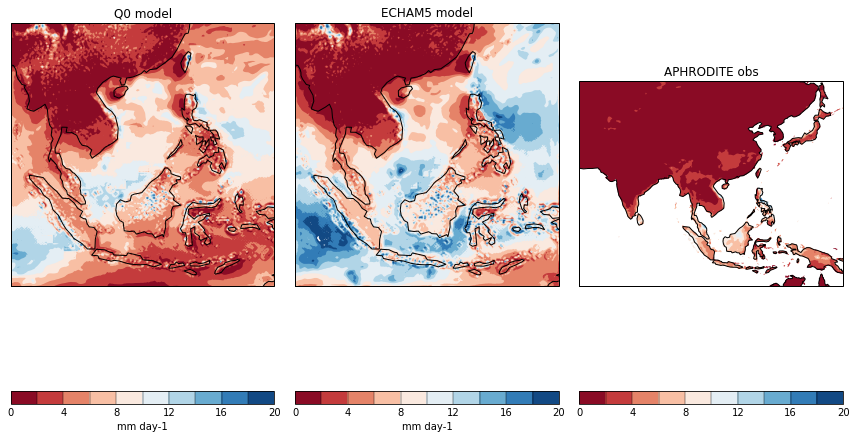

In [29]:
# Directory name where data is read from
indir = os.path.join(DATADIR, 'climatology')

# load cahpa model data
cahpa_cube = iris.load_cube(indir + '/cahpa.a.OND.mean.baseline.pr.mmday-1.nc')

# load cahpb model data
cahpb_cube = iris.load_cube(indir + '/cahpb.a.OND.mean.baseline.pr.mmday-1.nc')

# load APHRODITE data
obs_cube   = iris.load_cube(indir + '/aphro.a.OND.mean.baseline.pr.mmday-1.nc')

# Do some plotting!
# Create a figure of the size 12x10 inches
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)           # Create a new subplot for the model data; 1 row x 3 columns, 1st plot
levels = range(0, 22, 2)       # Define the contour levels for all plots

# Note this is where cube slicing is needed as you can only plot 2-coordinate
# dimensions with qplt.contourf, so here we have selected time[0] as there is only
# one timestep (the baseline 1961-1990 mean)
qplt.contourf(cahpa_cube[0], levels=levels, cmap=cm.RdBu)
                               

plt.title('Q0 model')          # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.subplot(1, 3, 2)           # Create a new subplot for the model data; 1 row x 3 columns, 2nd plot
qplt.contourf(cahpb_cube[0], levels=levels, cmap=cm.RdBu)

plt.title('ECHAM5 model')       # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.subplot(1, 3, 3)           # Create a new subplot for the observed data 1 row x 3 columns, 3rd plot
                               # This plot will be centred and below the two model plots
qplt.contourf(obs_cube[0], levels=levels, cmap=cm.RdBu)

plt.title('APHRODITE obs')     # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.tight_layout()             # automatically adjusts subplot(s) to fit in to the figure area
plt.show()

<div class="alert alert-block alert-success">
<b>Question:</b> 
    <br>What are the differences between the following plots for cahpa, cahpb and APHRODITE? Note the colour bars. 
    <br>Where are the largest daily rainfall rates distributed?
    <br>Why do you think this is happening?
</div>

<b>Answer:</b> *(Double click here to fill in the answers as you run and analyse each code block below)*<br>

<b>What differences do you see between the three plots?</b>


<b>Location of greatest rainfall</b>
<br> *cahpa*: 
<br> *cahpb*: 
<br> *aphrodite*:


<b>What is happening and why?</b>


<b>How could comparison be made easier?</b>

<a id='2.5'></a>
## 2.5 Region extraction 

If you have an area or region you want to focus on, you can extract data for the region of interest. This example works through how to constrain your cube by latitude and longitude.



__i) Extract the area around Kuala Lumpur for each of the three datasets, by specifiying latitude and longitude coordinates__

<div class="alert alert-block alert-success">
<b>Question:</b> Sort these jumbled values into the correct latitude and longitude extent for Kuala Lumpur, then enter them into the code block below so that they can be used to extract APHRODITE's precipitation data over the city. 
    <br> 3.48
    <br> 102.15
    <br> 101.25
    <br> 2.74

In [33]:
# Enter the ordered latitude and longitude coordinates for Kuala Lumpur here:
lon=( , ) # longitude (East - West extent)
lat=( , ) # latuitude (South - North extent)


SyntaxError: invalid syntax (<ipython-input-33-57eea7ac4596>, line 2)

In [38]:
# Solution: 
lon=(101.25, 102.15)
lat=(2.74, 3.48)

Run the code block below to extract the specified lat, lon coordinates from the **APHRODITE** dataset:

In [ ]:
# Note that the Aphrodite data are on a regular grid (unlike the  model data) so real latitudes and longitudes are
# used to define the region around KL (more on this in section 2.6)
obs_cube_KL = obs_cube.intersection(latitude=lat, longitude=lon)

# save the constrained cube to directory
outfile = os.path.join(DATADIR, 'APHRODITE', 'aphro.pm.6190.KL.nc')
iris.save(obs_cube_KL, outfile)

<div class="alert alert-block alert-info">
<b>Note:</b><br> <b>PRECIS uses a rotated grid</b> for these simulations, so the co-ordinates required are different to real world coordinates.


To extract the area around Kuala Lumpur for HadCM3Q0 (cahpa) and ECHAM5 (cahpb) driven simulations, we must specify the **rotated latitude and longitude coordinates**. These are highlighted in green in the code below.

Run the code below to constrain the cahpa and cahpb data to Kuala Lumpur: 


In [42]:
# Constrain the cube area over Kuala Lumpur (KL).
# PRECIS uses a rotated grid, so the co-ordinates required are different to real world coordinates.

for jobid in ['cahpa', 'cahpb']:
    # Directory name where data are read from and stored to
    infile = os.path.join(DATADIR, 'netcdf', jobid, jobid + '.pm.1981_1983.pr.norim.mmday-1.nc')
    
    # Load the baseline precipitation data using the KL_constraint - the command below
    # loads the data into a cube constrained by the area chosen
    data = iris.load_cube(infile)
    # All grid cells whose longitudes and latitudes lie within the limits shown will be selected.
    data_KL = data.intersection(grid_longitude=(-8.17, -7.43),
                                grid_latitude=(-12.10, -11.38))

    # save the constrained cube
    outfile = os.path.join(DATADIR, 'netcdf', jobid, jobid + '.pm.1981_1983.pr.norim.mmday-1.KL.nc')
    iris.save(data_KL, outfile)

PermissionError: [Errno 13] Permission denied: b'/project/precis/worksheets/data/netcdf/cahpa/cahpa.pm.1981_1983.pr.norim.mmday-1.KL.nc'

<a id='2.6'></a>
## 2.6 Mean annual cycle calculation

Average over a given area (e.g KL) to calculate multi-annual monthly mean values. 


__j) We now calculate monthly mean fields for 1961-1990 for each of the twelve months for the KL area__

In [50]:
for jobid in ['cahpa', 'cahpb']:
    # Set up the path to the data
    infile = os.path.join(DATADIR, 'netcdf', jobid, jobid + '.pm.1981_1983.pr.norim.mmday-1.KL.nc')
    
    # Load the data extracted around Kuala Lumpur created in previous step
    data = iris.load_cube(infile)

    # Add monthly coord categorisation to the time dimension coordinate
    iris.coord_categorisation.add_month_number(data, 'time', name='month_number')

    # Calculate monthly mean values
    monthly_mean = data.aggregated_by(['month_number'], iris.analysis.MEAN)

    # Calculate area averaged monthly mean rainfall 
    monthly_mean = monthly_mean.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN)

    # Save the area averaged monthly mean data
    outfile = os.path.join(DATADIR, 'climatology', jobid + '.monmean.1981_1983.pr.norim.mmday-1.KL.nc')
    iris.save(monthly_mean, outfile)
    

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'grid_latitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'grid_longitude'.
  warnings.warn(msg.format(self.name()))


PermissionError: [Errno 13] Permission denied: b'/project/precis/worksheets/data/climatology/cahpa.monmean.1981_1983.pr.norim.mmday-1.KL.nc'

__k) Plot the KL area averaged monthly mean precipitation amount in mm/day for the HadCM3Q0 and ECHAM5 driven PRECIS runs__ 


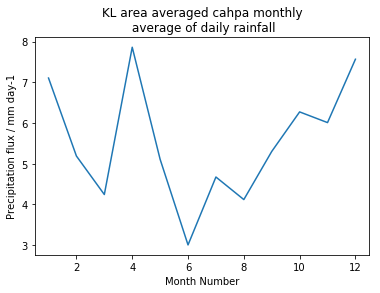

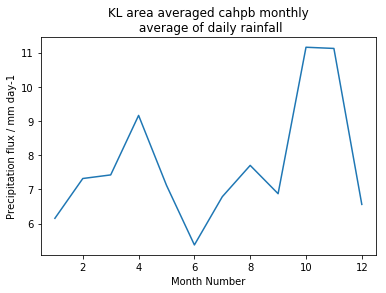

In [51]:
for jobid in ['cahpa', 'cahpb']:
    # Load the model cube
    inpath = os.path.join(DATADIR, 'climatology', jobid + '.monmean.1981_1983.pr.norim.mmday-1.KL.nc')
    cube = iris.load_cube(inpath)
    
    # Quick line plot for each cube 
    qplt.plot(cube.coord('month_number'), cube, label=jobid)
    plt.title('KL area averaged ' + jobid + ' monthly\n average of daily rainfall')
    ax = plt.gca()
    ax.xaxis.set_label_text('Month Number')
    ax.set_xlim(0.5, 12.5)
    plt.show()

<div class="alert alert-block alert-success">
<b>Question:</b> Considering the plots of capha and cahpb data, note down their approximate values in mm day-1 for the following features: 

- Which month experiences the most rainfall? (also note the amount)
- If a second rainfall peak exists in another season, note the month and amount,
- Which month experiences the least rainfall? (also note the amount)

What comparisons can be made about these two datasets?
</div>

<b>Answer:</b><br>
    
<b>HadCM3Q0 (cahpa)</b>
- Most rainfall: *month, amount*
- Secondary peak of rainfall:  *month, amount*
- Least rainfall:  *month, amount*

<b>ECHAM5 (cahpb)</b>
- Most rainfall: *month, amount*
- Secondary peak of rainfall:  *month, amount*
- Least rainfall:  *month, amount*

<b>How comparable are these datasets? How are they different?</b><br>


__l) Now by following the same methodology as above in step k), find the multi-annual monthly means (1961-1990) over the KL area for APHRODITE observations__

In [52]:
# Dirctories to load and save to
path_in = 'monthly/APHRODITE/' 
path_out = 'monthly/climatology/'

# Load the KL extracted data created in previous step
aphrod = iris.load_cube(path_in + 'aphro.pm.6190.05216.rr8.ext.mmday.nc')

# Add monthly coord categorisation to the time dim coordinate
iris.coord_categorisation.add_month_number(aphrod, 'time', name='month_number')

# Now calculate monthly means
aphro_monthly_mean = aphrod.aggregated_by(['month_number'], iris.analysis.MEAN)

# create the area averaged monthly mean of daily rainfall 
aphro_monthly_mean = aphro_monthly_mean.collapsed(['longitude', 'latitude'], iris.analysis.MEAN)

# Save output
iris.save(aphro_monthly_mean, path_out + 'aphro.monmean.baseline.05216.rr8.ext.mmday.nc')

OSError: One or more of the files specified did not exist:
    * "/net/home/h03/ramato/git/PyPRECIS/notebooks/monthly/APHRODITE/aphro.pm.6190.05216.rr8.ext.mmday.nc" didn't match any files

<div class="alert alert-block alert-success">
<b>Question:</b> Plot the APHRODITE observations, compare with the HadCM3Q0 and ECHAM5 driven PRECIS runs. What are the differences between the observations and models; what months are the differences greatest?
</div>

<b>Answer:</b><br>
*Write your findings here...*


<a id='2.7'></a>
## 2.7 Comparing models and observations

In section 2.4 we saw how to plot model output on individual maps, but for proper comparison, **spatial model and observation fields must be on the same grid.**

**You should regrid to the coarsest resolution grid.** For the data used here, the observations have the coarsest resolution so we will regrid the model data onto the observation grid.

Recall that the PRECIS model data are on a grid known as a **Rotated Grid**. The idea is that the "real" north pole in the Arctic is shifted such that the equator relative to our rotated pole then runs through the centre of the regional model domain.

__m) Regrid the multiannual OND mean model fields onto the observations grid__

Here we use the `regrid` method to regrid the target cube. Here we will use linear interpolation. First, load in the data.


In [56]:
# directory where data is stored
data_path = os.path.join(DATADIR, 'climatology')

# load cahpa
cahpa_model_cube = iris.load_cube(data_path + '/cahpa.a.OND.mean.baseline.pr.mmday-1.nc')
# load cahpb
cahpb_model_cube = iris.load_cube(data_path + '/cahpb.a.OND.mean.baseline.pr.mmday-1.nc')
# load APHRODITE
obs_cube = iris.load_cube(data_path + '/aphro.a.OND.mean.baseline.pr.mmday-1.nc')

Before we can regrid any data, both the model and observation datasets must have a **specified coordinate system**. 

In this case, APHRODITE's coordinate system is missing from the original NetCDF file, but the observations are on a regular longitude-latitude grid so the correct coordinate system is [WGS84](https://epsg.io/32600/). 

In the code below, we define the WGS84 coordinate system and then apply it to the x- and y-axes (i.e. longitudes and latitudes) of the observations.  

The coordinate system used by the model (the rotated grid) is already defined.


In [57]:
# Define WGS84 projection for obs data
wgs84 = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, inverse_flattening=298.257223563)

# Apply WGS84 to obs cube
obs_cube.coord(axis='x').coord_system = wgs84
obs_cube.coord(axis='y').coord_system = wgs84

# Print out and compare the two coordinate systems
print(obs_cube.coord_system())
print(cahpa_model_cube.coord_system())

GeogCS(semi_major_axis=6378137.0, semi_minor_axis=6356752.314245179)
RotatedGeogCS(75.0, 289.0, ellipsoid=GeogCS(6371229.0))


The next few lines of code **regrid the model data from rotated pole to the regular grid used by the observations**. 

From the plots created in section 2.4, we know that the area covered by APHRODITE data is larger than the PRECIS model domain. Hence, the **extrapolation mode** is set to `mask` so that any grid cells on the APHRODITE grid which do not overlap with model grid cells are masked `off`; otherwise, the model data would be interpolated and would produce misleading results.

In [60]:
# Regrid the climate model data onto APHRODITE grid
cahpa_regrid = cahpa_model_cube.regrid(obs_cube, iris.analysis.Nearest(extrapolation_mode='mask'))
cahpb_regrid = cahpb_model_cube.regrid(obs_cube, iris.analysis.Nearest(extrapolation_mode='mask'))

# Save output
iris.save(cahpa_regrid, data_path + '/cahpa.a.OND.mean.baseline.pr.mmday-1.rg.nc')
iris.save(cahpb_regrid, data_path + '/cahpb.a.OND.mean.baseline.pr.mmday-1.rg.nc')

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/analysis/_scipy_interpolate.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


Now that the model grids have been regridded to the observation cube, use the code block below to : 
<br>(i) load the NetCDF files,
<br>(ii) then plot the APHRODITE and model data again (as in section 2.4) to compare them visually once again.

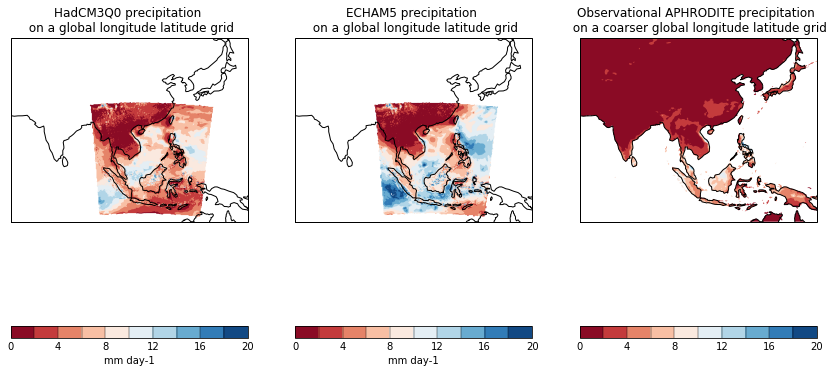

In [61]:
# Directory name where data is read from
indir = os.path.join(DATADIR, 'climatology')

# load cahpa model data
cahpa_cube = iris.load_cube(indir + '/cahpa.a.OND.mean.baseline.pr.mmday-1.rg.nc')

# load cahpb model data
cahpb_cube = iris.load_cube(indir + '/cahpb.a.OND.mean.baseline.pr.mmday-1.rg.nc')

# load APHRODITE data
obs_cube   = iris.load_cube(indir + '/aphro.a.OND.mean.baseline.pr.mmday-1.nc')

# Do some plotting!
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
levels = range(0, 22, 2)


qplt.contourf(cahpa_cube[0], levels=levels, cmap=cm.RdBu)
plt.title('HadCM3Q0 precipitation \n on a global longitude latitude grid')
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.subplot(1, 3, 2) 
qplt.contourf(cahpb_cube[0], levels=levels, cmap=cm.RdBu)
plt.title('ECHAM5 precipitation \n on a global longitude latitude grid')
ax = plt.gca()
ax.coastlines()

plt.subplot(1, 3, 3)
qplt.contourf(obs_cube[0], levels=levels, cmap=cm.RdBu)
plt.title('Observational APHRODITE precipitation \n on a coarser global longitude latitude grid')
ax = plt.gca()
ax.coastlines()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Question:</b> What differences do you see?
</div>

__n) Find the difference between the model and the observation OND multiannual mean fields and plot maps to view the differences__

We can simply subtract the model data from the observations.  There is a subtract function within Iris but it cannot be used here.  The model cubes contain extra coordinates which are not present in the obs cube; Iris requires all coordinates within the cubes to match exactly.

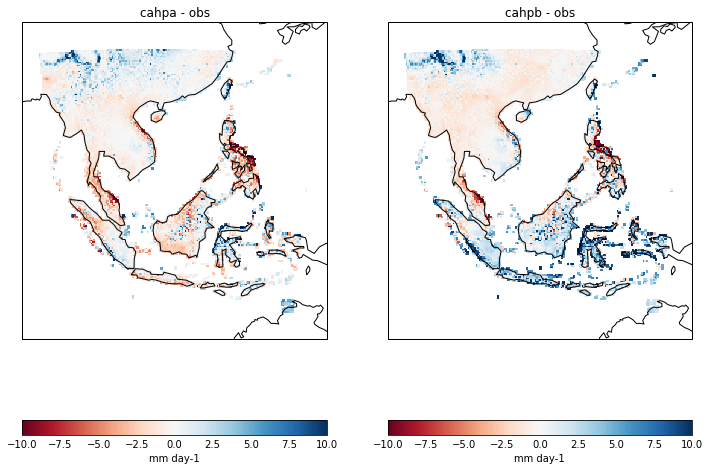

In [62]:
# Make sure units are the same
obs_cube.units = cahpb_cube.units

# Make recieving cube
cahpa_obs_diff = obs_cube.copy()
cahpb_obs_diff = obs_cube.copy()

# Replace data with the differences
cahpa_obs_diff.data = cahpa_cube.data - obs_cube.data

# cahpb - aphrodite differences
cahpb_obs_diff.data = cahpb_cube.data - obs_cube.data

# Save the differences
# iris.save(cahpa_obs_diff, data_path + 'diff.cahpa_aphro.OND.baseline.nc')
# iris.save(cahpb_obs_diff, data_path + 'diff.cahpb_aphro.OND.baseline.nc')

# Plotting
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)           # Create a new subplot for the first differences, 2 rows, 1 column, 1st plot

# Only plot the region containing data. We use the intersection method to do this.
qplt.pcolormesh(cahpa_obs_diff[0].intersection(longitude=(90, 135), latitude=(-20, 32)), 
                vmax=10, vmin=-10, 
                cmap=plt.get_cmap('RdBu')) # Note this is where cube slicing is needed as you can only plot 2-coordinate
                               # dimensions with qplt.contourf, so here we have selected time[0] as there is only
                               # one timestep (the baseline 1961-1990 mean)

plt.title('cahpa - obs')       # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.subplot(1, 2, 2)           # Create a new subplot for the model data 2 row, 2 columns, 2nd plot
qplt.pcolormesh(cahpb_obs_diff[0].intersection(longitude=(90, 135), latitude=(-20, 32)),
             vmax=10, vmin=-10,
             cmap=plt.get_cmap('RdBu'))

plt.title('cahpb - obs')       # plots a title for the plot
ax = plt.gca()                 # gca function that returns the current axes
ax.coastlines()                # adds coastlines defined by the axes of the plot

plt.show()

<div class="alert alert-block alert-success">
We have now created difference plots; to more easily validate the model(s) directly against observations. 

<b>Questions:</b> 
- Why has the data over the oceans disappeared?
- Which of the two model datasets (cahpa and cahpb) has the greatest wet bias? In which region? 
- Are there any areas in cahpa or cahpb with a strong dry bias? Roughly what is the extent of this bias (in mm/day)? 
</div>

<b>Answers</b>
- The data over the oceans has disappeared because [...] 

- The greatest wet bias occus in model [...], in region [...] 

- A strong dry bias exists in model [...] in region [...] (roughly [...] mm/day drier than APHRODITE observations).  


<a id='2.8'></a>
## 2.8 Climatological mean and annual cycle for an ensemble

So far data from two models downscaled with PRECIS have been analysed. In this section we will look at some addional HadCM3 ensemble memebers and the CRU bservational data set. 

The CRU data are a monthly global land-only dataset (1901-present) at 0.5 degree resolution. Nine variables are available, including mean, min, max temperature and precipitation. For further details please see: http://www.cru.uea.ac.uk/~timm/grid/CRU_TS_2_1.html

This gives us an ensemble of RCM data:

* HadCM3Q0 (cahpa)
* ECHAM5 (cahpb)
* HadCM3Q3 (cahpc)
* HadCM3Q10 (cahpd)
* HadCM3Q11 (cahpe)
* HadCM3Q13 (cahpf)

And observational datasets:

* APHRODITE
* CRU

Taking an ensemble approach allows us to account for a range of uncertainty in the model projections.

Write a series of scripts to do the following:

__o) Calculate the OND seasonal mean and annual cycle (for the KL area) for 1.5m temperature and precipitation for CRU and APHRODITE observations__

__p) Calculate OND seasonal-mean and monthly-mean anomalies for the KL area for the 4 additional HadCM3Q ensemble members (cahpc, cahpd, cahpe & cahpf)__

__q) Plot a series of figures that shows 1) the monthly cycles of temperature and rainfall comparing the 6 models and the observations; and 2) the monthly differences between the models and observations__

In [ ]:
'''
Here are some useful varibles  you might like to use in your scripts
'''
# Some helpful data locations
DATADIR = '/project/precis/worksheets/data'
APHRODIR = os.path.join(DATADIR, 'APHRODITE')
CRUDIR = os.path.join(DATADIR, 'CRU')
CLIMDIR = os.path.join(DATADIR, 'climatology')
MODELDIR = os.path.join(DATADIR, 'netcdf')

# Some helpful model variables
JOBID = ['cahpa', 'cahpb', 'cahpc', 'cahpd', 'cahpe', 'cahpf']
STASHCODES = ['03236', '05216'] # 03236 = temperature, 05216 = precipitation

# Kuala Lumpur domains...
# ... in roatated pole coordinates
grid_longitude=(-8.17, -7.43)
grid_latitude=(-12.10, -11.38)
# ... in true lat-lon coordiates
longitude=(101.25, 102.15)
latitude=(2.74, 3.48)

In [ ]:
'''
o) Calculate the OND seasonal-mean and monthly-mean 1.5m temperature and precipitation 
for the KL area, for CRU and APHRODITE observations
'''
# Load APHRODITE data

# Load CRU data

# Extract KL area

# Add OND season catagorisation

# Add monthly catagorisation

# Extract season

# Aggregate cubes

# Find KL area average

# Check and add cube metadata

# Save cubes to CLIMDIR
# Remember to use the same naming convention we used earlier


In [ ]:
'''
p) Calculate OND seasonal-mean and monthly-mean anomalies for the KL area 
for the 4 additional HadCM3Q ensemble members (cahpc, cahpd, cahpe & cahpf)
'''
# Load ensemble members
# Remember you need to do this for both precipitation AND temperature

# Regrid ensemble members onto observational grid
# Remember you need to check your model and obs cubes have the appropriate coordinate systems defined

# Extract the KL area. Remember you are now working in true lat-lon coordinates!

# Find OND and monthly means

# Calculate model anomalies
# Remember temp anomaly   = model - CRU data
#          precip anomaly = model - APHRO data

# Check cube metadata consitency and save


<div class="alert alert-block alert-success">
    <b>Question:</b> What difference would it make if we first extracted the KL area and <em>then</em> regrid the models? <br> 
Which order is best for preserving data integrity?
</div>

<b>Answer:</b><br> 
    

__q) Create four figures:__
    
    i) the monthly cycle of temperature (model and observations) 
    ii) the monthly cyce of rainfall (model and observations)
    iii) the monthly temperature anomaly for each model
    iv) the monthly precipitation anomaly for each model

In [ ]:
'''
Plot 1: The monthly cycle of temperature (model and observations)
'''


In [ ]:
'''
Plot 2: The monthly cycle of precipitation (model and observations)
'''


In [ ]:
'''
Plot 3: The monthly temperature anomaly for each model
'''


In [ ]:
'''
Plot 4: The monthly precipitation anomaly for each model
'''


<div class="alert alert-block alert-success">
    <b>Question:</b> How could you summarise the ensemble variability amongst model members in a plot?
</div>

<b>Answer:</b><br> 
    

<div class="alert alert-block alert-success">
    <b>Question:</b> How does the monthly temperature and precipitation anomaly compare to the OND average?
</div>

<b>Answer:</b><br> 
    

<div class="alert alert-block alert-success">
<b>Question:</b> What are the advantages and disadvantages of plotting spatial maps of temperature and rainfall variability over Kuala Lumpur?
</div>

<b>Answer:</b><br> 
    

<b>This completes worksheet 2a.</b><br>
You have used Python and Iris to validate the model's climatology (30 years of baseline data: 1961-1990) against observations, in order to analyse the model's capability of representing real-world trends. <br>
To do so, you have:
- calculated and plotted multiannual seasonal and monthly mean data,
- regridded rotated pole model data to a regular latitude-longitude grid,
- created difference plots to compare model data with observations, and 
- written your own code to do all of these post-processing and analysis tasks with an multi-model ensemble!

In worksheet 2b, you will consider future model projections and their changes with respect to the baseline period (calculated in this worksheet).

© Crown Copyright 2018, Met Office